# Beyond GLMs
This notebook accompanies "Modern Machine Learning Far Outperforms GLMs at Predicting Spikes". We exploring other Machine Learning algorithms for spike prediction and offer this as a Python template.

### Table of contents
0. Loading data
0. Define helper functions for scoring
0. Define Models
0. Model Comparison
0. Appendix: Hyperparameter optimization

## Dependencies
Basics
- numpy
- pandas
- scipy
- matplotlib

Methods
- sklearn
- pyglmnet (glm)
- xgboost
- theano (NN)
- keras (NN)

Other
- Bayes

In [86]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import scipy.io


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

#for plots
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.xaxis.set_tick_params(size=6)
    ax.yaxis.set_tick_params(size=6)

colors=['#F5A21E', '#02A68E', '#EF3E34', '#134B64', '#FF07CD','b']


# 1. Data
Below we load two datasets available on CRCNS: a [Macaque M1](http://crcns.org/data-sets/movements/dream/downloading-dream) (from [Stevenston et al. 2011](http://jn.physiology.org/content/106/2/764.short)) and a [Rat Hippocampus](http://crcns.org/data-sets/hc/hc-2/about-hc-2) from [Mizuseki et al. 2009](http://www.ncbi.nlm.nih.gov/pubmed/19874793).

The data has been organized in Matlab into neat arrays for easy loading here.

#### Load data

In [2]:
m1_imported = scipy.io.loadmat('../data/4Hugo_new.mat')

### 1.1 Covariates

In [3]:
data = pd.DataFrame()
data['time'] =  m1_imported['time'][0]
data['handPos_x'] =  m1_imported['handPos'][0]
data['handPos_y'] =  m1_imported['handPos'][1]
data['handVel_x'] =  m1_imported['handVel'][0]
data['handVel_y'] =  m1_imported['handVel'][1]
data.head() 

,time,handPos_x,handPos_y,handVel_x,handVel_y
0,12.591,0.002905,-0.303636,-0.011201,-0.006237
1,12.641,0.002260,-0.303869,-0.010743,-0.000833
2,12.691,0.002399,-0.303631,0.017680,0.012094
3,12.741,0.004010,-0.302399,0.044667,0.038700
4,12.791,0.006386,-0.300673,0.042202,0.017021


### Plot raw M1 data

This gives some intuitive feeling for the type of data we're working with.

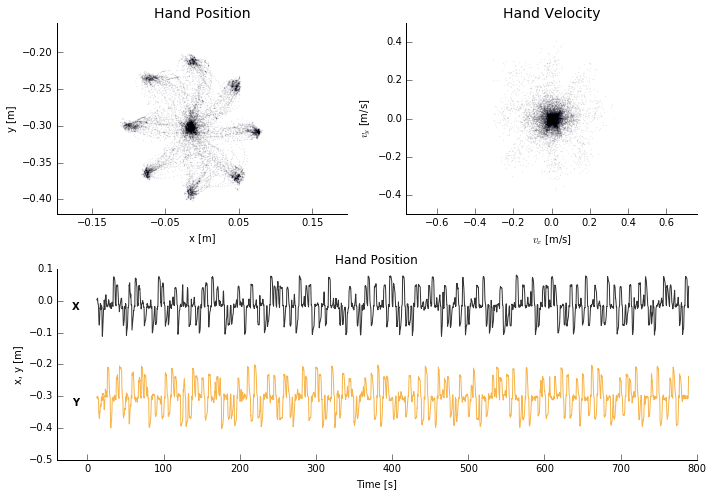

In [4]:
plt.figure(figsize=(10,10))
plt.rcParams['font.size'] = 10
plt.rcParams['font.weight'] = 'medium'
ldata = m1_imported['spikes'].shape

# Position scatter
ts = 14
gs0 = gridspec.GridSpec(3, 2)
plt.subplot(gs0[0,0])
simpleaxis(plt.gca())
plt.scatter(data['handPos_x'], data['handPos_y'], s=.1, alpha=.1)

plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axis('equal')
plt.title('Hand Position',fontsize=ts)
plt.ylim([-0.42,-0.16])
plt.xlim([-0.15,0.15])
plt.xticks(np.arange(-0.15,0.2, .1))

# Velocity scatter
plt.subplot(gs0[0,1])
simpleaxis(plt.gca())
plt.scatter(data['handVel_x'], data['handVel_y'], s=.1, alpha=.1)

plt.xlabel('$v_x$ [m/s]')
plt.ylabel('$v_y$ [m/s]')
plt.axis('equal')
plt.title('Hand Velocity',fontsize=ts)

# Position trace
plt.subplot(gs0[1,:])
a=plt.gca()
simpleaxis(a)
a.text(-20,-.03,'X',weight='bold')
a.text(-20,-.33,'Y',weight='bold')
alpha = 0.8
lw = 1
plt.plot(data['time'], data['handPos_x'], 'k-', alpha=alpha, lw=lw)
plt.plot(data['time'], data['handPos_y'], '-', color=colors[0], alpha=alpha, lw=lw)
a.axis([-40,800,-0.5,0.1])

plt.xlabel('Time [s]')
plt.ylabel('x, y [m]')
plt.title('Hand Position')


plt.tight_layout()
plt.show()


#### Compute more covariates/features

These will be used as the 'engineered' features for improving the GLM's performance.

In [5]:
data['velDir'] = np.arctan2(data['handVel_y'], data['handVel_x'])
data['cos_velDir'] = np.cos(data['velDir'])
data['sin_velDir'] = np.sin(data['velDir'])
data['speed'] = np.sqrt(data['handVel_x'].values**2+data['handVel_y'].values**2)
r = np.arctan2(data['handPos_y'], data['handPos_x'])
data['cos_PosDir'] = np.cos(r)
data['sin_PosDir'] = np.sin(r)
data['radial_Pos'] = np.sqrt(data['handPos_x'].values**2+data['handPos_y'].values**2)
data.head()

,time,handPos_x,handPos_y,handVel_x,handVel_y,velDir,cos_velDir,sin_velDir,speed,cos_PosDir,sin_PosDir,radial_Pos
0,12.591,0.002905,-0.303636,-0.011201,-0.006237,-2.633523,-0.873685,-0.486491,0.012820,0.009568,-0.999954,0.303650
1,12.641,0.002260,-0.303869,-0.010743,-0.000833,-3.064245,-0.997010,-0.077271,0.010775,0.007437,-0.999972,0.303877
2,12.691,0.002399,-0.303631,0.017680,0.012094,0.599956,0.825360,0.564606,0.021420,0.007900,-0.999969,0.303641
3,12.741,0.004010,-0.302399,0.044667,0.038700,0.713933,0.755792,0.654812,0.059100,0.013258,-0.999912,0.302426
4,12.791,0.006386,-0.300673,0.042202,0.017021,0.383375,0.927408,0.374053,0.045505,0.021233,-0.999775,0.300741


# 3. Cross-validation
It's important to 

1. evaluate the performance of a method on held-out data
2. train as as much data as you can
3. have confidence in your results (see comic). 

These three criteria are met with cross-validation. The method below returns a cross-validated pseudo-R2 score given data and an algorithm.

[![crossvalidate](http://imgs.xkcd.com/comics/linear_regression.png)](http://xkcd.com/1725/)

In [6]:
from sklearn.model_selection import KFold


def poisson_pseudoR2(y, yhat, ynull):
    # This is our scoring function. Implements McFadden's pseudo-R2
    yhat = yhat.reshape(y.shape)
    eps = np.spacing(1)
    L1 = np.sum(y*np.log(eps+yhat) - yhat)
    L1_v = y*np.log(eps+yhat) - yhat
    L0 = np.sum(y*np.log(eps+ynull) - ynull)
    LS = np.sum(y*np.log(eps+y) - y)
    R2 = 1-(LS-L1)/(LS-L0)
    return R2

def fit_cv(X, Y, algorithm = 'glm_pyglmnet', n_cv=10, verbose=1):
    """Performs cross-validated fitting. Returns (Y_hat, pR2_cv); a vector of predictions Y_hat
    and a list of pR2 scores on each fold pR2_cv
    
    X  = input data
    Y = spiking data
    algorithm = a function of (Xr, Yr, Xt) {training data Xr and response Yr and testing features X}
                and returns the predicted response Yt
    n_cv = number of cross-validations folds
    
    """
    if np.ndim(X)==1:
        X = np.transpose(np.atleast_2d(X))

    cv_kf = KFold(n_splits=n_cv, shuffle=True, random_state=42)
    skf  = cv_kf.split(X)

    i=1
    Y_hat=np.zeros(len(Y))
    pR2_cv = list()
    for idx_r, idx_t in skf:
        if verbose > 1:
            print( '...runnning cv-fold', i, 'of', n_cv)
        i+=1
        Xr = X[idx_r, :]
        Yr = Y[idx_r]
        Xt = X[idx_t, :]
        Yt = Y[idx_t]

        Yt_hat = eval(algorithm)(Xr, Yr, Xt)
        Y_hat[idx_t] = Yt_hat

        pR2 = poisson_pseudoR2(Yt, Yt_hat, np.mean(Yr))
        pR2_cv.append(pR2)

        if verbose > 1:
            print( 'pR2: ', pR2)

    if verbose > 0:
        print("pR2_cv: %0.6f (+/- %0.6f)" % (np.mean(pR2_cv),
                                             np.std(pR2_cv)/np.sqrt(n_cv)))

    return Y_hat, pR2_cv


In [7]:

def plot_model_comparison(models_for_plot, models=[], color='r', title=None, labels=[],fs=12):
    """Just makes a comparision bar plot."""
    plt.plot([-1, len(models_for_plot)], [0,0],'--k', alpha=0.4)
    
    if not labels: 
        labels = models_for_plot

    mean_pR2 = list()
    sem_pR2 = list()

    for model in models_for_plot:
        PR2_art = models[model]['PR2']
        mean_pR2.append(np.mean(PR2_art))
        sem_pR2.append(np.std(PR2_art)/np.sqrt(np.size(PR2_art)))

    plt.bar(np.arange(np.size(mean_pR2)), mean_pR2, 0.8, align='center',
            ecolor='k', alpha=.9, color=color, ec='w', yerr=np.array(sem_pR2),
            tick_label=labels)
    plt.plot(np.arange(np.size(mean_pR2)), mean_pR2, 'k.', markersize=15)

    plt.ylabel('Pseudo-R2',fontsize=fs)
    simpleaxis(plt.gca())
    if title:
        plt.title(title)

## Define Models

### GLM

Note: Different problems may require different regularization parameters __alpha__ and __reg_lambda__. The __learning_rate, tol__, and __max_iter__ should also be adjusted to ensure convergence (they can be touchy).

In [8]:
from pyglmnet import GLM

def glm_pyglmnet(Xr, Yr, Xt):
    glm = GLM(distr='poisson', alpha=0.1, tol=1e-8, verbose=0,
              reg_lambda=[0],
              learning_rate=0.01, max_iter=10000, eta=2.0, random_state=1)

    
    glm.fit(Xr, Yr)
    Yt = glm[-1].predict(Xt)
    
    return Yt



### XGBoost

Note: Many of these parameters __(learning rate, # estimators, subsampling, max_depth, and gamma)__ should be optimized for the prediction problem at hand. Optimization can be done with a grid search, randomized search, or with Bayesian Optimization (see appendix at bottom.)

In [20]:
import xgboost as xgb

def xgb_run(Xr, Yr, Xt):
    params = {'objective': "count:poisson", #for poisson output
    'eval_metric': "logloss", #loglikelihood loss
    'seed': 2925, #for reproducibility
    'silent': 1,
    'learning_rate': 0.05,
    'min_child_weight': 2, 'n_estimators': 580,
    'subsample': 0.6, 'max_depth': 5, 'gamma': 0.4}        
     

    dtrain = xgb.DMatrix(Xr, label=Yr)
    dtest = xgb.DMatrix(Xt)

    num_round = 200
    bst = xgb.train(params, dtrain, num_round)

    Yt = bst.predict(dtest)
    return Yt


### Neural Nets

Note: Again, these parameters should be optimized. We highlight __dropout__, elastic net regularization __l1, l2__, and the number of nodes in the hidden layers. Optimization can be done with a grid search, randomized search, or with Bayesian Optimization (see appendix at bottom.)

There are many, many options for implementing NNs. One might also test maxnorm regularization, e.g. RMSprop instead of Nadam, more or less layers, or different batch sizes or number of epochs.

In [10]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.regularizers import l1l2
from keras.optimizers import Nadam


def nn(Xr, Yr, Xt):

    params = {'dropout': 0.5,
              'l1': 0.0,
              'l2': 0.0,
              'n1': 1980, #number of layers in 1st hidden layer
              'n2': 18}

    if np.ndim(Xr)==1:
        Xr = np.transpose(np.atleast_2d(Xr))

    model = Sequential()
    model.add(Dense(params['n1'], input_dim=np.shape(Xr)[1], init='glorot_normal',
                activation='relu', W_regularizer=l1l2(params['l1'],params['l2'])))
    model.add(Dropout(params['dropout']))
    model.add(Dense(params['n2'], init='glorot_normal'
                    , activation='relu',W_regularizer=l1l2(params['l1'],params['l2'])))
    model.add(Dense(1,activation='softplus'))

    optim = Nadam()
    model.compile(loss='poisson', optimizer=optim,)
    hist = model.fit(Xr, Yr, batch_size = 32, nb_epoch=5, verbose=0, validation_split=0.0)
    Yt = model.predict(Xt)[:,0]
    return Yt



Using Theano backend.


### Other methods
These methods aren't highlighted in the paper but may help to improve the ensemble.
##### Random Forest

In [11]:
from sklearn.ensemble import RandomForestRegressor

def rf(Xr, Yr, Xt):
    params = {'max_depth': 15,
             'min_samples_leaf': 4,
             'min_samples_split': 5,
             'min_weight_fraction_leaf': 0.0,
             'n_estimators': 471}
    
    clf = RandomForestRegressor(**params)
    clf.fit(Xr, Yr)
    Yt = clf.predict(Xt)
    return Yt

##### K-nearest neighbors

In [12]:
from sklearn.neighbors import KNeighborsRegressor

def knn(Xr, Yr, Xt):
    neigh = KNeighborsRegressor(n_neighbors=5,weights='distance')
    neigh.fit(Xr, Yr) 
    Yt = neigh.predict(Xt)
    #returns list of probabilities for each category
    return Yt

### Ensemble

We found a simple weighted average of the above methods to be very successful. The following function is defined like the above functions, but note that the input data Xr and Xt will be the _outputs_ Yt_hat of the above functions.

In [32]:
from sklearn.linear_model import LinearRegression

def lin_comb(Xr, Yr, Xt):
    lr = LinearRegression()
    lr.fit(Xr, Yr)
    Yt = lr.predict(Xt)
    return Yt

from sklearn.linear_model import HuberRegressor

def huber_comb(Xr, Yr, Xt):
    lr = HuberRegressor(epsilon=1.35)
    lr.fit(Xr, Yr)
    Yt = lr.predict(Xt)
    return Yt

## Method comparison

Let's take a single neuron from the M1 set and test the above methods.

First we'll test on the set of _original features_.

In [69]:
X = data[['handPos_x','handPos_y','handVel_x','handVel_y']].values

neuron_n = 4
y = m1_imported['spikes'][neuron_n]

Let's plot the neuron's response vs. velocity direction.

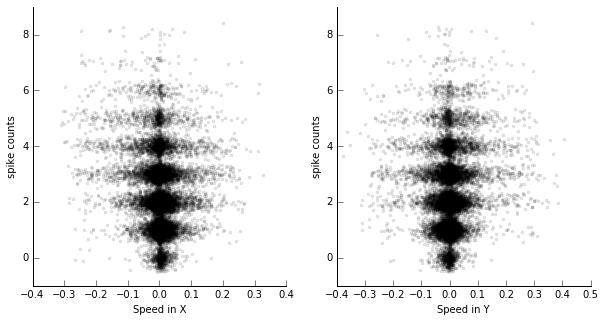

In [90]:
plt.figure(figsize=(10,5))

y_noise = np.random.randn(np.size(y))
nnoise = 0.2

plt.subplot(121)
simpleaxis(plt.gca())

plt.plot(data['handVel_x'], y+nnoise*y_noise, 'k.', alpha=0.1)
plt.xlabel('Speed in X')
plt.ylabel('spike counts')

plt.subplot(122)
simpleaxis(plt.gca())

plt.plot(data['handVel_y'], y+nnoise*y_noise, 'k.', alpha=0.1)
plt.xlabel('Speed in Y')
plt.ylabel('spike counts')

plt.show()

Now we can fit the data using a method from above:

In [71]:
#We'll store results here.
Models = dict()

In [72]:
Yt_hat, PR2 = fit_cv(X, y, algorithm = 'glm_pyglmnet', n_cv=8, verbose=2)

Models['glm'] = dict()
Models['glm']['Yt_hat'] = Yt_hat
Models['glm']['PR2'] = PR2

...runnning cv-fold 1 of 8
pR2:  0.0216337539178
...runnning cv-fold 2 of 8
pR2:  0.0174929973938
...runnning cv-fold 3 of 8
pR2:  0.0113682602762
...runnning cv-fold 4 of 8
pR2:  0.0175930987304
...runnning cv-fold 5 of 8
pR2:  0.0146271215758
...runnning cv-fold 6 of 8
pR2:  0.0160879694669
...runnning cv-fold 7 of 8
pR2:  0.0221403399882
...runnning cv-fold 8 of 8
pR2:  0.0231245200142
pR2_cv: 0.018009 (+/- 0.001347)


Or all at once:

In [73]:
methods = ['nn','xgb_run','rf','knn']

for method in methods:
    print('Running '+method+'...')
    Yt_hat, PR2 = fit_cv(X, y, algorithm = method, n_cv=8, verbose=1)
    Models[method] = dict()
    Models[method]['Yt_hat'] = Yt_hat
    Models[method]['PR2'] = PR2

Running nn...
pR2_cv: 0.189489 (+/- 0.004567)
Running xgb_run...
pR2_cv: 0.302062 (+/- 0.004382)
Running rf...
pR2_cv: 0.304464 (+/- 0.006721)
Running knn...
pR2_cv: 0.190224 (+/- 0.011230)


Now we can make the ensemble. 

In [81]:
X_ens = list()
for method in list(Models.keys()):
    X_ens.append(Models[method]['Yt_hat'])
    
# The columns of X_ens are the predictions of each of the above methods
X_ens = np.transpose(np.array(X_ens))

Yt_hat, PR2 = fit_cv(X_ens, y, algorithm = 'lin_comb', n_cv=8, verbose=2)
Models['ens'] = dict()
Models['ens']['Yt_hat'] = Yt_hat
Models['ens']['PR2'] = PR2

...runnning cv-fold 1 of 8
pR2:  0.288983245895
...runnning cv-fold 2 of 8
pR2:  0.299578209427
...runnning cv-fold 3 of 8
pR2:  0.301455150157
...runnning cv-fold 4 of 8
pR2:  0.323794919148
...runnning cv-fold 5 of 8
pR2:  0.344351679506
...runnning cv-fold 6 of 8
pR2:  0.304881998022
...runnning cv-fold 7 of 8
pR2:  0.310782291262
...runnning cv-fold 8 of 8
pR2:  0.3072612337
pR2_cv: 0.310136 (+/- 0.005629)


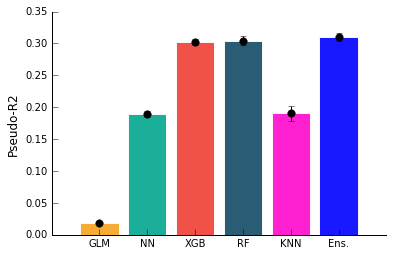

In [88]:
plot_model_comparison(['glm', 'nn','xgb_run','rf','knn','ens'],models=Models,
                      color=colors,labels = ['GLM','NN','XGB','RF','KNN','Ens.'])